## https://www.sbert.net/docs/usage/semantic_textual_similarity.html

In [136]:
import pandas as pd
import itertools
from tqdm.notebook import tqdm

# https://github.com/UKPLab/sentence-transformers
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer("distilbert-base-nli-stsb-mean-tokens")
import calcbench as cb

cb.enable_backoff()

In [151]:
cb.companies_raw(index="SP")

In [186]:
ticker_to_SIC = {c["ticker"]: c["sic_code"] for c in cb.companies_raw(index="SP500")}

In [67]:
categories = [
    (
        "environmental",
        """biodiversity, carbon, carbon negative, carbon neutral, carbon zero, clean-up, clean, clean tech, climate change, climate positive, contamination, discharge, emission, energy-efficient, environmental, environmental risk, fuel, fuel efficiency, green, greenhouse gas, hazardous, low carbon, natural resource, net-zero emission, pollution, remediation, sustainability, sustainable, toxic, waste, water, zero carbon, zero net carbon""",
    ),
    (
        "social",
        """accident, antiracism, consumer protection, customer privacy, employee relation, equal, equal pay, equity, gender equality, health, human right, justice, labor relation, labor standard, racial equity, racial awareness, racial justice, working condition""",
    ),
    (
        "goverance",
        """advocacy, antitrust, board independence, code of ethic, compensation, corporate culture, corporate governance, corruption, governance risk, justice, political lobbying, scandal, shareholder right, stability, stewardship, transparency""",
    ),
]

In [57]:
esg_embeddings = model.encode(
    [words for _, words in categories], convert_to_tensor=True
)

In [133]:
with tqdm() as progress_bar:
    search_results = list(
        cb.document_search(
            company_identifiers=cb.tickers(index="SP500"),
            document_name="ManagementsDiscussionAndAnalysis",
            all_history=True,
            period_type="annual",
            progress_bar=progress_bar,
        )
    )

search_results = [
    s for s in search_results if s.document_type == "10-K"
]  # Remove amended filings

0it [00:00, ?it/s]

In [137]:
document_contents = [(d, d.get_contents_text()) for d in tqdm(search_results)]

  0%|          | 0/5294 [00:00<?, ?it/s]

In [138]:
md_a_embeddings = model.encode(
    [contents for _, contents in document_contents],
    convert_to_tensor=True,
    show_progress_bar=True,
)

Batches:   0%|          | 0/166 [00:00<?, ?it/s]

In [141]:
cosine_scores = util.pytorch_cos_sim(esg_embeddings, md_a_embeddings)

In [223]:
distances = pd.DataFrame(
    cosine_scores.numpy(),
    columns=pd.MultiIndex.from_tuples(
        [
            (ticker_to_SIC[document.ticker] // 1000, document.ticker, document.fiscal_year)
            for document, _ in document_contents
        ],
        names=["SIC", "ticker", "year"],
    ),
    index=[c for c, _ in categories],
).T.sort_index(level=[0, 1], ascending=[True, False])

In [233]:
sic_year_means = distances.groupby(['SIC', 'year']).mean()

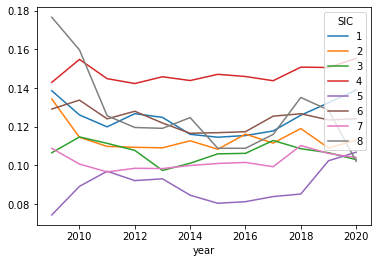

In [249]:
sic_year_means.environmental.unstack(level=0).plot()

In [126]:
distances.style.background_gradient(cmap="viridis")

In [129]:
distances.to_excel(
    r"C:\Users\andre\Dropbox (Calcbench)\andrew\md_a_esg_similarity.xlsx"
)